In [1]:
import numpy as np
import pandas as pd


id_stopword_dict = pd.read_csv(
    '/Users/imamghozali/Documents/Master/Semester1/RPL/Data/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

# print(id_stopword_dict)

data1 = pd.read_csv("/Users/imamghozali/Documents/Master/Semester1/RPL/Data/IDHSD_RIO_unbalanced_713_2017.txt",
                    sep=" ", delimiter="\t", encoding='latin-1')


alay_dict = pd.read_csv(
    '/Users/imamghozali/Documents/Master/Semester1/RPL/Data/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original',
                                      1: 'replacement'})

data1['Label'] = data1['Label'].map({'Non_HS': 1, 'HS': 0})

print(data1)


     Label                                              Tweet
0        1  RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1        1  RT @baguscondromowo: Mereka terus melukai aksi...
2        1  Sylvi: bagaimana gurbernur melakukan kekerasan...
3        1  Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...
4        1  RT @lisdaulay28: Waspada KTP palsu.....kawal P...
..     ...                                                ...
708      0  Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....
709      0  Betul bang hancurkan merka bang, musnahkan chi...
710      0  Sapa Yg bilang Ahok anti korupsi!?, klo grombo...
711      0  Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...
712      0  Mudah2an gw ketemu sama SI BABI IWAN BOPENG DI...

[713 rows x 2 columns]


/Users/imamghozali/opt/anaconda3/envs/python36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Label', ylabel='count'>

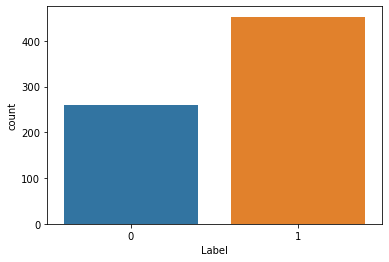

In [3]:
import seaborn as sns

sns.countplot('Label',data=data1)


In [4]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()
from nltk.tokenize import word_tokenize 
import nltk
# from keras.preprocessing.text import Tokenizer

# nltk.download()

def lowercase(text):
    return text.lower()


def remove_unnecessary_char(text):
    # Remove every URL
    text = re.sub(
        '((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub('\n', ' ', text)  # Remove every '\n'
    text = re.sub('\r', ' ', text)  # Remove every '\r'
    text = re.sub('(?i)rt', ' ', text)  # Remove every retweet symbol
    text = re.sub('@[^\s]+[ \t]', '', text)  # Remove every username
    text = re.sub('(?i)user', '', text)  # Remove every username
    text = re.sub('(?i)url', ' ', text)  # Remove every url
    text = re.sub(r'\\x..', ' ', text)  # Remove every emoji
    text = re.sub('  +', ' ', text)  # Remove extra spaces
    # Remove characters repeating more than twice
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)

    return text


def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text


alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))


def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])


def remove_stopword(text):
    text = ' '.join(
        ['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text)  # Remove extra spaces
    text = text.strip()
    return text


def stemming(text):
    return stemmer.stem(text)


def preprocess(text):
    text = lowercase(text)
    text = remove_unnecessary_char(text)
    text = remove_nonaplhanumeric(text)
    text = normalize_alay(text)
    text = remove_stopword(text)
    text = stemming(text)
    text = nltk.tokenize.word_tokenize(text)
    ordered_tokens = set()
    result = []
    # filter duplicate words
    # for word in text:
    #     if word not in ordered_tokens:
    #         ordered_tokens.add(word)
    #         result.append(word)
    # text = result      
    return text

print(preprocess("@saidaqil Andi kerap melakukan transaksi rutin secara daring atau online. Menurut Andi belanja online lebih praktis & murah."))
print(preprocess("@saidaqil apa maksud pernyataan. Anda? Apa anda mengaminkan kriminalisasi Ahok?? Hati2 jg dg mulutmu pak!"))
# data1 = data1.drop(['HS'], axis=1)
# result = []
# for item in data1.iloc[:, 0]:
#     # for num in item:    
#         # print(preprocess(item))
#         result.append(preprocess(item))

# print(result[0])

['andi', 'kerap', 'transaksi', 'rutin', 'daring', 'online', 'andi', 'belanja', 'online', 'praktis', 'murah']
['maksud', 'nyata', 'amin', 'kriminalisasi', 'ahok', 'hati', 'hati', 'mulut']


In [5]:
x=data1['Tweet']
y=data1['Label']

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42,test_size=0.2)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

570 570
143 143


In [7]:
import string

# Create an iterator object that returns words properly formatted for Word2Vec training
class TweetIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for tweet in self.dataset:
            # Make all characters lower-case
            tweet = tweet.lower()
            sentence= preprocess(tweet)
            words = [w for w in sentence if w != '']
            # for sentence in tweet.split('.')[:-1]:
            #     # Clean string of all punctuation
            #     # sentence = sentence.translate(self.translator)
            #     sentence= preprocess(sentence)
            #     words = [w for w in sentence]

            yield words

sentences = TweetIterator(x_train)
# print(list(sentences))


In [138]:
import gensim

w2v_model = gensim.models.Word2Vec(sentences,sg=1, vector_size = 200, window=5, min_count=5)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))



Vocabulary Size: 241 - Embedding Dim: 200


In [139]:
print(w2v_model.wv.most_similar('anjing', topn=3))

def word2token(word):
    try:
        return w2v_model.wv.key_to_index[word]
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

[('ahok', 0.9990167617797852), ('orang', 0.9989354014396667), ('dukung', 0.9988754987716675)]


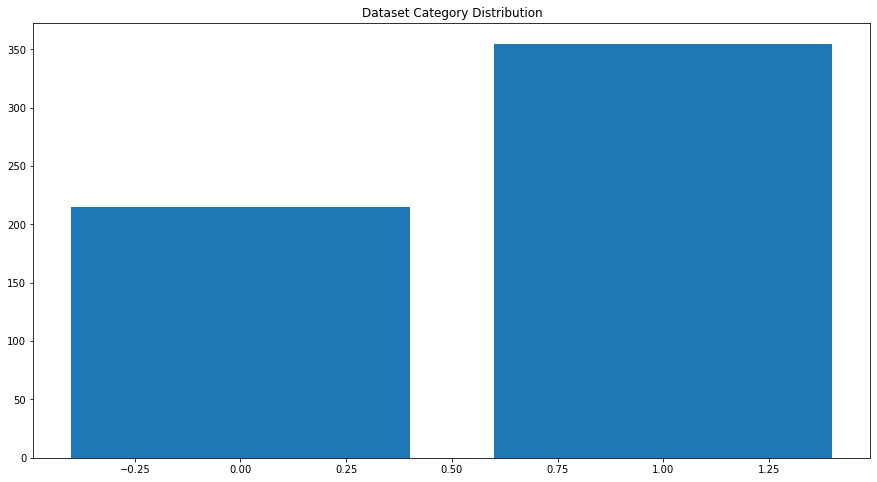

In [140]:
import matplotlib.pyplot as plt

categories, ccount = np.unique(y_train, return_counts=True)

# Using a figsize this big seems dirty. It's the only way I figured to make
# the x labels not overlap. I suck at plotting, sorry
plt.figure(figsize=(15, 8))
plt.title("Dataset Category Distribution")
plt.bar(categories, ccount, align='center')
plt.show()

In [141]:
# Import everything that will be used
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import string
# Create an iterator that formats data from the dataset proper for
# LSTM training

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 200

# Samples of categories with less than this number of samples will be ignored
DROP_THRESHOLD = 0

class SequenceIterator:
    def __init__(self, dataset_x,dataset_y, drop_threshold, seq_length):
        self.dataset_x = dataset_x
        self.dataset_y = dataset_y
        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(dataset_y, return_counts=True)
        
        self.seq_length = seq_length
        
        # Samples of categories with less than this number of samples will be ignored
        self.drop_categos = []
        for cat, count in zip(self.categories, self.ccount):
            if count < drop_threshold:
                self.drop_categos.append(cat)
        
        # Remaining categories
        self.categories = np.setdiff1d(self.categories, self.drop_categos)
        
    def __iter__(self):
        for tweet, cat in zip(self.dataset_x, self.dataset_y):
            if cat in self.drop_categos:
                continue
            
            # Make all characters lower-case
            tweet = tweet.lower()
            
            # Clean string of all punctuation
            # tweet = tweet.translate(self.translator)
            tweet= preprocess(tweet)


            words = np.array([word2token(w) for w in tweet[:self.seq_length] if w != ''])
                                
            yield (words, cat)

sequences = SequenceIterator(x_train,y_train, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

set_x = []
set_y = []
for w, c in sequences:
    set_x.append(w)
    set_y.append(cat_dict[c])
    
# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)

print(set_x.shape)
print(set_y.shape)

(570, 200)
(570,)


In [90]:
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size, weights=[w2v_weights], input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 100)          24100     
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 200, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 104,601
Trainable params: 104,601
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

stop = EarlyStopping(
    monitor='loss', 
    mode='min',
    patience=5
)

checkpoint= ModelCheckpoint(
    filepath='./model_txt_biLstm',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [21]:
history=model.fit(set_x,set_y,batch_size=1024,epochs=20,
          validation_split=0.2,callbacks=[stop,checkpoint])

Train on 456 samples, validate on 114 samples
Epoch 1/20
456/456 [==============================] - 5s 12ms/step - loss: 0.6865 - acc: 0.6162 - val_loss: 0.6539 - val_acc: 0.6404
Epoch 2/20
456/456 [==============================] - 3s 7ms/step - loss: 0.6624 - acc: 0.6184 - val_loss: 0.6414 - val_acc: 0.6404
Epoch 3/20
456/456 [==============================] - 3s 7ms/step - loss: 0.6580 - acc: 0.6184 - val_loss: 0.6432 - val_acc: 0.6404
Epoch 4/20
456/456 [==============================] - 3s 6ms/step - loss: 0.6528 - acc: 0.6184 - val_loss: 0.6339 - val_acc: 0.6404
Epoch 5/20
456/456 [==============================] - 3s 7ms/step - loss: 0.6458 - acc: 0.6184 - val_loss: 0.6328 - val_acc: 0.6404
Epoch 6/20
456/456 [==============================] - 3s 8ms/step - loss: 0.6407 - acc: 0.6184 - val_loss: 0.6222 - val_acc: 0.6404


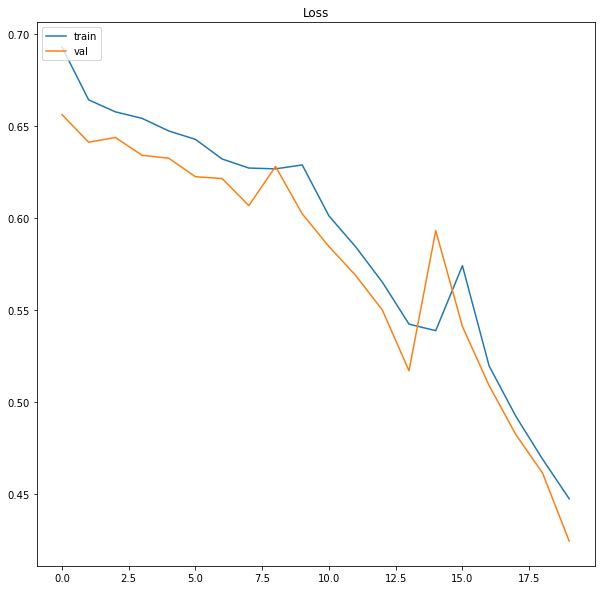

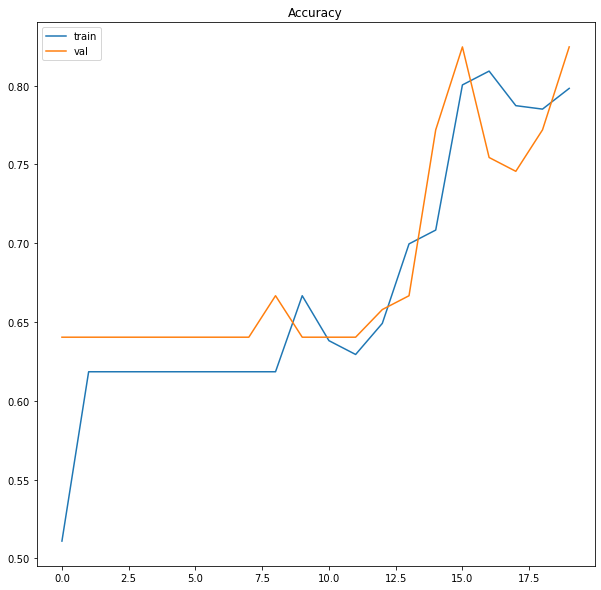

In [344]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [142]:
sequences = SequenceIterator(x_test,y_test, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}
set_x_test = []
set_y_test = []
for w, c in sequences:
    set_x_test.append(w)
    set_y_test.append(cat_dict[c])
    
# Padding sequences with 0.
set_x_test = pad_sequences(set_x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y_test = np.array(set_y_test)


In [346]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
MAX_SEQUENCE_LENGTH = 200

# tokenizer = Tokenizer(num_words=MAX_SEQUENCE_LENGTH)
# tokenizer.fit_on_texts(set_x_test)
# test_sequences = tokenizer.texts_to_sequences(set_x_test)
test_sequences_matrix = sequence.pad_sequences(set_x_test,maxlen=MAX_SEQUENCE_LENGTH)
accr = model.evaluate(test_sequences_matrix,y_test)


143/143 [==============================] - 1s 10ms/step


In [347]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lstm_prediction=model.predict(test_sequences_matrix)
res=[]
for prediction in lstm_prediction:
    if prediction[0]<0.5:
        res.append(0)
    else:
        res.append(1)
print(confusion_matrix(set_y_test,res))
print (classification_report(set_y_test, res))


[[22 23]
 [ 2 96]]
              precision    recall  f1-score   support

           0       0.92      0.49      0.64        45
           1       0.81      0.98      0.88        98

    accuracy                           0.83       143
   macro avg       0.86      0.73      0.76       143
weighted avg       0.84      0.83      0.81       143



In [151]:
from keras.optimizers import RMSprop

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size, weights=[w2v_weights], input_length=MAX_SEQUENCE_LENGTH))
model2.add(SpatialDropout1D(0.2))
model2.add(Bidirectional(LSTM(100,dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()
model2.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 200, 200)          48200     
_________________________________________________________________
spatial_dropout1d_22 (Spatia (None, 200, 200)          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 201       
Total params: 289,201
Trainable params: 289,201
Non-trainable params: 0
_________________________________________________________________


In [152]:
history=model2.fit(set_x,set_y,batch_size=1024,epochs=45,
          validation_split=0.2,callbacks=[stop,checkpoint])

Train on 456 samples, validate on 114 samples
Epoch 1/45
456/456 [==============================] - 21s 46ms/step - loss: 0.6764 - acc: 0.6162 - val_loss: 0.7528 - val_acc: 0.6404
Epoch 2/45
456/456 [==============================] - 9s 19ms/step - loss: 0.7779 - acc: 0.6184 - val_loss: 0.6587 - val_acc: 0.6404
Epoch 3/45
456/456 [==============================] - 9s 19ms/step - loss: 0.6625 - acc: 0.6184 - val_loss: 0.6504 - val_acc: 0.6404
Epoch 4/45
456/456 [==============================] - 8s 18ms/step - loss: 0.6595 - acc: 0.6184 - val_loss: 0.6488 - val_acc: 0.6404
Epoch 5/45
456/456 [==============================] - 9s 19ms/step - loss: 0.6582 - acc: 0.6184 - val_loss: 0.6471 - val_acc: 0.6404
Epoch 6/45
456/456 [==============================] - 8s 17ms/step - loss: 0.6544 - acc: 0.6184 - val_loss: 0.6452 - val_acc: 0.6404
Epoch 7/45
456/456 [==============================] - 8s 18ms/step - loss: 0.6554 - acc: 0.6184 - val_loss: 0.6431 - val_acc: 0.6404
Epoch 8/45
456/456 [==

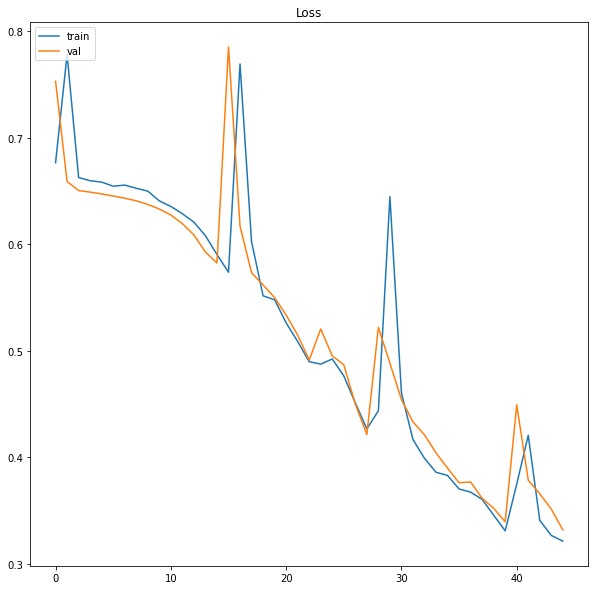

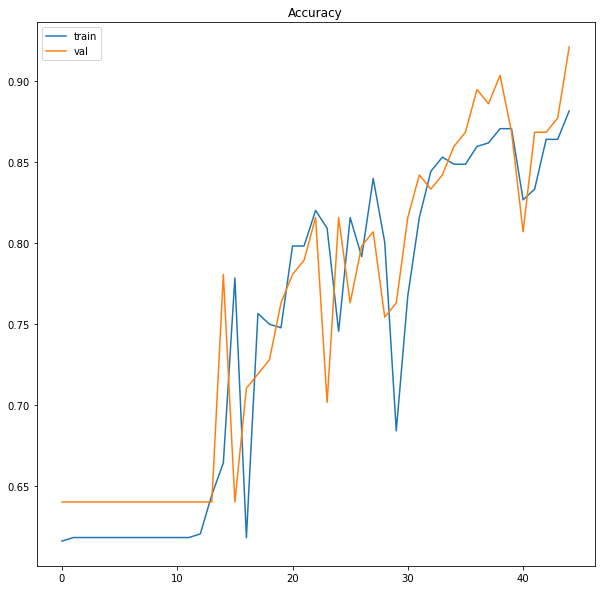

In [153]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [154]:
# print(y_test)
sequences = SequenceIterator(x_test,y_test, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}
# print(cat_dict)

set_x_test = []
set_y_test = []
for w, c in sequences:
    set_x_test.append(w)
    set_y_test.append(cat_dict[c])
    
# Padding sequences with 0.
set_x_test = pad_sequences(set_x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y_test = np.array(set_y_test)
# print(set_y_test)

In [147]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
MAX_SEQUENCE_LENGTH = 200

# tokenizer = Tokenizer(num_words=MAX_SEQUENCE_LENGTH)
# tokenizer.fit_on_texts(set_x_test)
# test_sequences = tokenizer.texts_to_sequences(set_x_test)
test_sequences_matrix = sequence.pad_sequences(set_x_test,maxlen=MAX_SEQUENCE_LENGTH)

accr = model.evaluate(test_sequences_matrix,y_test)

143/143 [==============================] - 1s 10ms/step


In [155]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lstm_prediction=model2.predict(test_sequences_matrix)
res=[]
for prediction in lstm_prediction:
    if prediction[0]<0.5:
        res.append(0)
    else:
        res.append(1)
print(confusion_matrix(set_y_test,res))
print (classification_report(set_y_test, res))

[[33 12]
 [ 5 93]]
              precision    recall  f1-score   support

           0       0.87      0.73      0.80        45
           1       0.89      0.95      0.92        98

    accuracy                           0.88       143
   macro avg       0.88      0.84      0.86       143
weighted avg       0.88      0.88      0.88       143

